# 하이브리드 검색(Hybrid Search)

---

## 1. 개념 이해

### 1.1 검색 방식 분류

#### 🔍 **의미론적 검색 (Semantic Search)**
- **정의**: 벡터 임베딩을 활용한 의미 기반 검색
- **특징**: 
  - 동의어와 문맥적 의미를 파악
  - 자연어 질의에 효과적
  - 유사도 기반 매칭
- **장점**: 의미적 연관성이 높은 문서 검색
- **단점**: 정확한 키워드 매칭 약함

#### 🔍 **키워드 검색 (Keyword Search)**
- **정의**: BM25 알고리즘 기반 키워드 매칭 검색
- **특징**:
  - 직접적인 단어/구문 매칭
  - 계산 효율성 높음
  - 전통적인 정보검색 방식
- **장점**: 정확한 키워드 매칭, 빠른 처리 속도
- **단점**: 의미적 유사성 파악 제한적

#### 🔍 **하이브리드 검색 (Hybrid Search)**
- **정의**: 키워드 검색과 의미론적 검색의 결합
- **특징**:
  - EnsembleRetriever를 통한 구현
  - 가중치 조정으로 성능 최적화
  - 두 검색 방식의 시너지 효과
- **장점**: 포괄적이고 정확한 검색 결과
- **단점**: 구현 복잡도 증가, 계산 비용 상승

### 1.2 BM25 알고리즘 이해

BM25는 TF-IDF의 확장된 버전으로, 다음 공식을 사용합니다:

```markdown
BM25(qi, D) = IDF(qi) × (f(qi, D) × (k1 + 1)) / (f(qi, D) + k1 × (1 - b + b × |D| / avgdl))
```

- `f(qi, D)`: 문서 D에서 단어 qi의 빈도
- `|D|`: 문서 D의 길이
- `avgdl`: 평균 문서 길이
- `k1, b`: 조정 매개변수

---

## 2. 환경 설정

### 2.1 필수 라이브러리 설치

```bash
# 기본 라이브러리
pip install langchain langchain-community langchain-openai
pip install langchain-chroma

# 검색 및 평가 라이브러리
pip install rank_bm25 kiwipiepy
pip install ranx ranx-k

# 데이터 처리
pip install pandas numpy matplotlib seaborn
```

### 2.2 환경 변수 설정

In [1]:
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()

True

### 2.3 기본 라이브러리 Import
- uv pip install ranx-k

In [4]:
import os
import json
from glob import glob
from pprint import pprint
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

# # 한글 폰트 인식 - Windows
# import matplotlib 
# font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# matplotlib.rc('font', family=font_name)

# 한글 폰트 인식 - Mac
import matplotlib
matplotlib.rc('font', family='AppleGothic')

# 마이너스 부호 인식
matplotlib.rc("axes", unicode_minus = False)

# LangChain 핵심
from langchain_core.documents import Document
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# 데이터 처리
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 한국어 처리
from kiwipiepy import Kiwi

# 평가
import ranx
import ranx_k

---

## 3. 데이터 준비

### 3.1 텍스트 데이터 로드

In [5]:
def load_text_files(file_patterns):
    """
    다양한 형식의 텍스트 파일을 로드
    
    Args:
        file_patterns (list): 파일 패턴 리스트
    
    Returns:
        list: Document 객체 리스트
    """
    documents = []
    
    for pattern in file_patterns:
        files = glob(pattern)
        for file_path in files:
            try:
                loader = TextLoader(file_path, encoding='utf-8')
                docs = loader.load()
                documents.extend(docs)
                print(f"✅ {file_path} 로드 완료")
            except Exception as e:
                print(f"❌ {file_path} 로드 실패: {e}")
    
    return documents

# 로드할 문서의 패턴 정의
# 예시: 'data/*.txt', 'data/*.json' 등
# 현재는 'data/*_KR.md' 패턴만 사용
file_patterns = [
    'data/*_KR.md',
    # 'data/*.txt',
    # 'data/*.json'
]
raw_documents = load_text_files(file_patterns)
print(f"총 {len(raw_documents)}개 문서 로드됨")

✅ data\리비안_KR.md 로드 완료
✅ data\테슬라_KR.md 로드 완료
총 2개 문서 로드됨


### 3.2 문서 분할 및 전처리

In [6]:
def create_text_splitter():
    """
    한국어 최적화된 텍스트 분할기 생성
    """
    return RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        separators=['\n\n', '\n', r'(?<=[.!?])\s+'],
        chunk_size=300,
        chunk_overlap=50,
        is_separator_regex=True,
        keep_separator=True,
    )

def preprocess_documents(documents, company_mapping=None):
    """
    문서 전처리 및 메타데이터 추가
    
    Args:
        documents (list): 원본 문서 리스트
        company_mapping (dict): 회사명 매핑 정보
    
    Returns:
        list: 전처리된 Document 객체 리스트
    """
    text_splitter = create_text_splitter()
    chunks = text_splitter.split_documents(documents)
    
    processed_docs = []
    for chunk in chunks:
        # 메타데이터 추가
        source_file = chunk.metadata.get('source', '')
        
        # 회사명 추출
        if company_mapping:
            company = 'unknown'
            for keyword, name in company_mapping.items():
                if keyword in source_file.lower():
                    company = name
                    break
        else:
            company = 'default'
        
        # Document 객체 생성
        doc = Document(
            # content 포맷팅에 수정을 함. >> xml 태그로 감싸고, 출처 문구 추가
            page_content=f"<Document>\n{chunk.page_content}\n</Document>\n<Source>이 문서는 '{company}'에 대한 문서입니다.</Source>",
            metadata={
                **chunk.metadata,
                'company': company,
                'language': 'ko',
                'chunk_length': len(chunk.page_content)
            }
        )
        processed_docs.append(doc)
    
    return processed_docs

# 회사명 매핑 정보
# 예시: 'tesla' -> '테슬라', 'rivian' -> '리비안'
# 실제 사용 시에는 더 많은 회사명을 추가할 수 있음
company_mapping = {
    '테슬라': '테슬라(tesla)',
    '리비안': '리비안(rivian)',
}

processed_docs = preprocess_documents(raw_documents, company_mapping)
print(f"총 {len(processed_docs)}개 청크 생성됨")

총 39개 청크 생성됨


In [7]:
# 결과 확인
for i, doc in enumerate(processed_docs[:3]+ processed_docs[-3:]):
    print(f"\n[청크 {i+1}]")
    print(f"회사: {doc.metadata['company']}")
    print(f"내용: {doc.page_content}")
    print("-" * 50)


[청크 1]
회사: unknown
내용: <Document>
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source>
--------------------------------------------------

[청크 2]
회사: unknown
내용: <Document>
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
- **주요 인물:** R. J. 스캐린지 (CEO)
- **제품:** 전기 자동차, 배터리
- **생산량 (2023):** 57,232대
- **서비스:** 전기 자동차 충전, 자동차 보험
- **수익 (2023):** 44억 3천만 미국 달러
- **순이익 (2023):** -54억 미국 달러
- **총 자산 (2023):** 168억 미국 달러
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source>
--------------------------------------------------

[청크 3]
회사: unknown
내용: <Document>
- **총 자산 (2023):** 168억 미국 달러
- **총 자본 (2023):** 91억 4천만 미국 달러
- **직원 수 (2023년 12월):** 16,790명
- **웹사이트:** rivian.com
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</Source>
--------------------------------------------------

[청크 4]
회사: unknown
내용: <Docum

---

## 4. 검색 방법론

### 4.1 의미론적 검색 (Semantic Search)

#### 4.1.1 벡터 저장소 생성

In [8]:
import os
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

def create_or_load_vector_store(documents, collection_name="hybrid_search_db"):
    """
    Chroma 벡터 저장소 생성 (기존 컬렉션이 있으면 로드하고, 없으면 새로 생성)
    
    Args:
        documents (list): Document 객체 리스트
        collection_name (str): 컬렉션 이름
    
    Returns:
        Chroma: 벡터 저장소 객체

    """
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    persist_directory = "./local_chroma_db"
    
    # 디렉토리와 컬렉션 파일이 존재하는지 확인
    if os.path.exists(persist_directory):
        try:
            # 기존 컬렉션 로드 시도
            vector_store = Chroma(
                collection_name=collection_name,
                embedding_function=embeddings,
                persist_directory=persist_directory
            )
            
            # 컬렉션에 문서가 있는지 확인
            if vector_store._collection.count() > 0:
                print(f"✅ 기존 벡터 저장소 로드 완료: {vector_store._collection.count()}개 문서")
                return vector_store
        except Exception as e:
            print(f"기존 컬렉션 로드 실패: {e}")
    
    # 새로운 벡터 저장소 생성
    vector_store = Chroma.from_documents(
        documents=documents,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=persist_directory,
        collection_metadata={'hnsw:space': 'cosine'}
    )
    print(f"✅ 새 벡터 저장소 생성 완료: {vector_store._collection.count()}개 문서")
    return vector_store

# 벡터 저장소 생성
vector_store = create_or_load_vector_store(processed_docs)

✅ 새 벡터 저장소 생성 완료: 39개 문서


#### 4.1.2 의미론적 검색 실행

In [9]:
def semantic_search(vector_store, query, k=5):
    """
    의미론적 검색 실행
    
    Args:
        vector_store: Chroma 벡터 저장소
        query (str): 검색 쿼리
        k (int): 반환할 문서 수
    
    Returns:
        list: 검색된 Document 객체 리스트
    """
    # 검색기 생성
    retriever = vector_store.as_retriever(search_kwargs={"k": k})
    
    # 검색 실행
    results = retriever.invoke(query)
        
    return results

# 검색 테스트
query = "리비안은 언제 설립되었나요?"
semantic_results = semantic_search(vector_store, query, k=3)

print(f"Query: {query}")
print(f"🔍 의미론적 검색 결과 ({len(semantic_results)}개)")
for i, doc in enumerate(semantic_results, 1):
    print(f"\n[{i}] 회사: {doc.metadata.get('company', 'N/A')}")
    print(f"내용: {doc.page_content[:150]}...")
    print("-" * 50)


Query: 리비안은 언제 설립되었나요?
🔍 의미론적 검색 결과 (3개)

[1] 회사: unknown
내용: <Document>
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
-...
--------------------------------------------------

[2] 회사: unknown
내용: <Document>
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</...
--------------------------------------------------

[3] 회사: unknown
내용: <Document>
Tesla는 내부 고발자 보복, 근로자 권리 침해, 안전 결함, 홍보 부족, Musk의 논란의 여지가 있는 발언과 관련된 소송, 정부 조사 및 비판에 직면했습니다.

## 역사

### 창립 (2003–2004)

Tesla Motors, Inc.는...
--------------------------------------------------


### 4.2 키워드 검색 (Keyword Search)

#### 4.2.1 한국어 토크나이저 설정

In [10]:
def setup_korean_tokenizer():
    """
    한국어 토크나이저 설정
    
    Returns:
        Kiwi: 한국어 토크나이저 객체
    """
    kiwi = Kiwi()
    
    # 사용자 정의 단어 추가 > 별도의 명사로 인지 할 수 있게 됨.
    custom_words = [
        ('리비안', 'NNP'),  # 고유명사
        ('테슬라', 'NNP'),  # 고유명사
        ('전기차', 'NNG'),  # 일반명사
    ]
    
    for word, pos in custom_words:
        kiwi.add_user_word(word, pos)
        print(f"✅ 단어 추가: {word} ({pos})")
    
    return kiwi

def korean_tokenizer(text, kiwi_model):
    """
    한국어 토크나이저 함수
    
    Args:
        text (str): 토큰화할 텍스트
        kiwi_model: Kiwi 모델 객체
    
    Returns:
        list: 토큰 리스트
    """
    return [token.form for token in kiwi_model.tokenize(text)]

# 토크나이저 설정
kiwi_model = setup_korean_tokenizer()

# 토큰화 테스트
test_text = "리비안은 언제 설립되었나요?"
tokens = korean_tokenizer(test_text, kiwi_model)
print(f"원문: {test_text}")
print(f"토큰: {tokens}")

✅ 단어 추가: 리비안 (NNP)
✅ 단어 추가: 테슬라 (NNP)
✅ 단어 추가: 전기차 (NNG)
원문: 리비안은 언제 설립되었나요?
토큰: ['리비안', '은', '언제', '설립', '되', '었', '나요', '?']


#### 4.2.2 BM25 검색기 생성
- uv pip install rank_bm25

In [11]:
def create_bm25_retriever(documents, kiwi_model, k=5):
    """
    BM25 검색기 생성
    
    Args:
        documents (list): Document 객체 리스트
        kiwi_model: Kiwi 토크나이저
        k (int): 반환할 문서 수
    
    Returns:
        BM25Retriever: BM25 검색기 객체
    """
    def preprocess_func(text):
        return korean_tokenizer(text, kiwi_model)
    
    # BM25 검색기 생성 >> 구문 일치 
    bm25_retriever = BM25Retriever.from_documents(
        documents=documents,
        preprocess_func=preprocess_func,
        k=k
    )
    
    print(f"✅ BM25 검색기 생성 완료: {len(documents)}개 문서 인덱싱")
    return bm25_retriever

# BM25 검색기 생성
bm25_retriever = create_bm25_retriever(processed_docs, kiwi_model, k=3)

✅ BM25 검색기 생성 완료: 39개 문서 인덱싱


In [12]:
# 검색 테스트
keyword_results = bm25_retriever.invoke(query)

print(f"Query: {query}")
print(f"🔍 키워드 검색 결과 ({len(keyword_results)}개)")
for i, doc in enumerate(keyword_results, 1):
    print(f"\n[{i}] 회사: {doc.metadata.get('company', 'N/A')}")
    print(f"내용: {doc.page_content[:150]}...")
    print("-" * 50)


Query: 리비안은 언제 설립되었나요?
🔍 키워드 검색 결과 (3개)

[1] 회사: unknown
내용: <Document>
### SolarCity 및 Model 3 (2016–2018)

Tesla는 2016년 11월 SolarCity를 26억 달러에 인수하여 Tesla Energy를 설립했습니다. 2017년 2월, Tesla Motors는 사명을 Tesla, Inc....
--------------------------------------------------

[2] 회사: unknown
내용: <Document>
Tesla는 내부 고발자 보복, 근로자 권리 침해, 안전 결함, 홍보 부족, Musk의 논란의 여지가 있는 발언과 관련된 소송, 정부 조사 및 비판에 직면했습니다.

## 역사

### 창립 (2003–2004)

Tesla Motors, Inc.는...
--------------------------------------------------

[3] 회사: unknown
내용: <Document>
- **Model S:** 리프트백 차체 스타일과 듀얼 모터, 전륜 구동 레이아웃을 갖춘 풀사이즈 고급차. Model S 개발은 2007년 이전에 시작되었으며 배송은 2012년 6월에 시작되었습니다.
- **Model X:** 듀얼 모터 또는 트리 ...
--------------------------------------------------


#### 4.2.3 BM25 점수 확인

In [13]:
def analyze_bm25_scores(bm25_retriever, query, kiwi_model, top_k=5):
    """
    BM25 점수 분석
    
    Args:
        bm25_retriever: BM25 검색기
        query (str): 검색 쿼리
        kiwi_model: Kiwi 토크나이저
        top_k (int): 상위 k개 결과
    """
    # 쿼리 토큰화
    tokenized_query = korean_tokenizer(query, kiwi_model)
    print(f"쿼리 토큰: {tokenized_query}")
    
    # BM25 점수 계산
    doc_scores = bm25_retriever.vectorizer.get_scores(tokenized_query)
    
    # 점수 정렬
    doc_scores_sorted = sorted(
        enumerate(doc_scores), 
        key=lambda x: x[1], 
        reverse=True
    )
    
    print(f"\n📊 상위 {top_k}개 문서의 BM25 점수:")
    print("-" * 80)
    
    for rank, (idx, score) in enumerate(doc_scores_sorted[:top_k], 1):
        doc = bm25_retriever.docs[idx]
        print(f"[{rank}] 점수: {score:.4f}")
        print(f"    회사: {doc.metadata.get('company', 'N/A')}")
        print(f"    내용: {doc.page_content[:100]}...")
        print("-" * 80)

# BM25 점수 분석
analyze_bm25_scores(bm25_retriever, query, kiwi_model)

쿼리 토큰: ['리비안', '은', '언제', '설립', '되', '었', '나요', '?']

📊 상위 5개 문서의 BM25 점수:
--------------------------------------------------------------------------------
[1] 점수: 4.3233
    회사: unknown
    내용: <Document>
### SolarCity 및 Model 3 (2016–2018)

Tesla는 2016년 11월 SolarCity를 26억 달러에 인수하여 Tesla Energ...
--------------------------------------------------------------------------------
[2] 점수: 4.1461
    회사: unknown
    내용: <Document>
Tesla는 내부 고발자 보복, 근로자 권리 침해, 안전 결함, 홍보 부족, Musk의 논란의 여지가 있는 발언과 관련된 소송, 정부 조사 및 비판에 직면했습니...
--------------------------------------------------------------------------------
[3] 점수: 3.6421
    회사: unknown
    내용: <Document>
- **Model S:** 리프트백 차체 스타일과 듀얼 모터, 전륜 구동 레이아웃을 갖춘 풀사이즈 고급차. Model S 개발은 2007년 이전에 시작되었으며 ...
--------------------------------------------------------------------------------
[4] 점수: 3.5874
    회사: unknown
    내용: <Document>
Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회사는 전기 자동차(BEV), 고정형 배터리 에너지 저장 장치, 태양 전지판, 태양...
-----------------------------

### 4.3 하이브리드 검색 (Hybrid Search)

In [14]:
def create_hybrid_retriever(vector_store, bm25_retriever, weights=None):
    """
    하이브리드 검색기 생성
    
    Args:
        vector_store: 벡터 저장소
        bm25_retriever: BM25 검색기
        weights (list): 가중치 [의미론적, 키워드]
    
    Returns:
        EnsembleRetriever: 하이브리드 검색기
    """
    if weights is None:
        weights = [0.5, 0.5]  # 기본값: 동일한 가중치
    
    # 의미론적 검색기 생성
    semantic_retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    
    # 앙상블 검색기 생성
    ensemble_retriever = EnsembleRetriever(
        retrievers=[semantic_retriever, bm25_retriever],
        weights=weights
    )
    
    print(f"✅ 하이브리드 검색기 생성 완료")
    print(f"   가중치: 의미론적 {weights[0]}, 키워드 {weights[1]}")
    
    return ensemble_retriever

# 하이브리드 검색기 생성
hybrid_retriever = create_hybrid_retriever(vector_store, bm25_retriever)

✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.5, 키워드 0.5


In [15]:
# 검색 테스트
hybrid_results = hybrid_retriever.invoke(query)

print(f"Query: {query}")
print(f"🔍 하이브리드 검색 결과 ({len(hybrid_results)}개)")
for i, doc in enumerate(hybrid_results, 1):
    print(f"\n[{i}] 회사: {doc.metadata.get('company', 'N/A')}")
    print(f"내용: {doc.page_content[:150]}...")
    print("-" * 50)


Query: 리비안은 언제 설립되었나요?
🔍 하이브리드 검색 결과 (7개)

[1] 회사: unknown
내용: <Document>
Tesla는 내부 고발자 보복, 근로자 권리 침해, 안전 결함, 홍보 부족, Musk의 논란의 여지가 있는 발언과 관련된 소송, 정부 조사 및 비판에 직면했습니다.

## 역사

### 창립 (2003–2004)

Tesla Motors, Inc.는...
--------------------------------------------------

[2] 회사: unknown
내용: <Document>
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
-...
--------------------------------------------------

[3] 회사: unknown
내용: <Document>
### SolarCity 및 Model 3 (2016–2018)

Tesla는 2016년 11월 SolarCity를 26억 달러에 인수하여 Tesla Energy를 설립했습니다. 2017년 2월, Tesla Motors는 사명을 Tesla, Inc....
--------------------------------------------------

[4] 회사: unknown
내용: <Document>
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</...
--------------------------------------------------

[5] 회사: unknown
내용: <Document>
- **Model S:** 리프트백 차체

---

## 5. 평가 및 비교

### 5.1 평가 데이터셋 준비

In [16]:
def load_evaluation_dataset(file_path):
    """
    평가 데이터셋 로드
    
    Args:
        file_path (str): 평가 데이터 파일 경로
    
    Returns:
        pandas.DataFrame: 평가 데이터셋
    """
    try:
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("지원하지 않는 파일 형식")
        
        print(f"✅ 평가 데이터셋 로드: {len(df)}개 질문")
        return df
    except Exception as e:
        print(f"❌ 데이터셋 로드 실패: {e}")
        return None

# 평가 데이터셋 로드

eval_df = load_evaluation_dataset("./data/synthetic_testset.csv")
eval_df.head(3)

✅ 평가 데이터셋 로드: 50개 질문


,user_input,reference_contexts,reference,synthesizer_name
0,"Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?","['Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자...","Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차...",single_hop_specifc_query_synthesizer
1,168억 미국 달러는 리브니의 무슨 항목에 해당합니까?,['- **회사 유형:** 상장\n- **거래소:** NASDAQ: RIVN\n- ...,168억 미국 달러는 2023년 기준 리브니의 총 자산에 해당합니다.,single_hop_specifc_query_synthesizer
2,2023년 기준 Rivian의 직원 수는 몇 명입니까?,['- **총 자본 (2023):** 91억 4천만 미국 달러\n- **직원 수 (...,"2023년 12월 기준 Rivian의 직원 수는 16,790명입니다.",single_hop_specifc_query_synthesizer


In [17]:
def prepare_evaluation_data(df):
    """
    평가 데이터 전처리
    
    Args:
        df (pandas.DataFrame): 원본 데이터프레임
    
    Returns:
        tuple: (질문 리스트, 정답 문서 리스트)
    """
    questions = df['user_input'].tolist()
    
    # 정답 문서 파싱
    reference_contexts = []
    for contexts in df['reference_contexts']:
        if isinstance(contexts, str):
            # 문자열을 리스트로 변환
            context_list = eval(contexts)
        else:
            context_list = contexts
        
        # Document 객체로 변환
        docs = [Document(page_content=ctx) for ctx in context_list]
        reference_contexts.append(docs)
    
    return questions, reference_contexts

# 평가 데이터 전처리
questions, reference_contexts = prepare_evaluation_data(eval_df)

# 평가 데이터 확인
for i, (q, refs) in enumerate(zip(questions[:3], reference_contexts[:3])):
    print(f"\n[질문 {i+1}]")
    print(f"질문: {q}")
    print(f"정답 문서: {len(refs)}개")
    for j, ref in enumerate(refs):
        print(f"  [{j+1}] 내용: {ref.page_content[:50]}...")  # 내용 일부만 출력
    print("-" * 50)

# 평가 데이터 확인
for i, (q, refs) in enumerate(zip(questions[-3:], reference_contexts[-3:])):
    print(f"\n[질문 {i+1}]")
    print(f"질문: {q}")
    print(f"정답 문서: {len(refs)}개")
    for j, ref in enumerate(refs):
        print(f"  [{j+1}] 내용: {ref.page_content[:50]}...")  # 내용 일부만 출력
    print("-" * 50)


[질문 1]
질문: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?
정답 문서: 1개
  [1] 내용: Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업...
--------------------------------------------------

[질문 2]
질문: 168억 미국 달러는 리브니의 무슨 항목에 해당합니까?
정답 문서: 1개
  [1] 내용: - **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** ...
--------------------------------------------------

[질문 3]
질문: 2023년 기준 Rivian의 직원 수는 몇 명입니까?
정답 문서: 1개
  [1] 내용: - **총 자본 (2023):** 91억 4천만 미국 달러
- **직원 수 (2023년 1...
--------------------------------------------------

[질문 1]
질문: Tesla의 Bitcoin 투자와 NASDAQ-100 상장, 그리고 2020년 주가 상승은 어떻게 연결되며, 이 세 가지가 Tesla의 전기차 사업 성장에 어떤 영향을 미쳤습니까?
정답 문서: 3개
  [1] 내용: <1-hop>

2021년 초, Tesla는 Bitcoin에 15억 달러를 투자하고 환경 ...
  [2] 내용: <2-hop>

Tesla는 2012년 6월 Model S 고급 세단을 출시했습니다. Mo...
  [3] 내용: <3-hop>

2019년 7월부터 2020년 6월까지 Tesla는 4분기 연속 흑자를 보...
--------------------------------------------------

[질문 2]
질문: Tesla의 Autopilot driver assistance system과 향후 출시 예정인 Autonomous driving technology 차량들은 무엇이며, 각각의 특징

### 5.2 ranx 라이브러리를 사용한 평가

In [18]:
def clean_document_content(doc_content):
    """
    문서 내용을 정규화하여 매칭 가능하도록 처리
    """
    if not doc_content:
        return ""
    
    # 문자열로 변환
    content = str(doc_content)
    
    # <Document> 태그 제거
    content = content.replace('<Document>', '').replace('</Document>', '')
    
    # 시작과 끝의 공백/개행 제거
    content = content.strip()
    
    # 연속된 공백을 단일 공백으로 변경
    import re
    content = re.sub(r'\s+', ' ', content)
    
    # 처음 100자만 사용 (고유 식별을 위해)
    return content[:100]

def evaluate_with_ranx(retriever, questions, reference_contexts, k=5):
    """
    ranx 라이브러리를 사용한 검색 성능 평가
    """
    # ranx 설치 확인
    try:
        from ranx import Qrels, Run, evaluate
    except ImportError:
        print("❌ ranx 라이브러리를 설치해주세요: pip install ranx")
        return None
    
    def extract_clean_content(doc):
        """문서에서 깔끔한 내용을 추출"""
        if doc is None:
            return None
            
        # 문자열인 경우
        if isinstance(doc, str):
            return clean_document_content(doc)
        
        # 딕셔너리인 경우
        if isinstance(doc, dict):
            # 여러 필드 시도
            for field in ['page_content', 'content', 'text', 'body']:
                if field in doc:
                    return clean_document_content(doc[field])
        
        # 문서 객체인 경우 (예: Langchain Document)
        if hasattr(doc, 'page_content'):
            return clean_document_content(doc.page_content)
        elif hasattr(doc, 'content'):
            return clean_document_content(doc.content)
        
        # 마지막 수단: 객체를 문자열로 변환
        return clean_document_content(str(doc))
    
    # 데이터 형식 변환
    qrels_dict = {}
    run_dict = {}
    
    print("🔄 검색 및 평가 데이터 준비 중...")
    
    total_matches = 0
    total_queries = len(questions)
    
    for i, (question, ref_docs) in enumerate(zip(questions, reference_contexts)):
        query_id = f"q_{i+1}"
        
        try:
            # 검색 실행
            retrieved_docs = retriever.invoke(question)
            
            # 정답 문서 내용 정규화
            ref_doc_contents = set()
            for ref_doc in ref_docs:
                clean_content = extract_clean_content(ref_doc)
                if clean_content:
                    ref_doc_contents.add(clean_content)
            
            # 검색된 문서 내용 정규화 및 점수 부여
            retrieved_doc_scores = {}
            found_relevant = 0
            
            for j, ret_doc in enumerate(retrieved_docs[:k]):
                clean_content = extract_clean_content(ret_doc)
                if clean_content:
                    # 점수는 순위 기반 (1위가 가장 높은 점수)
                    score = k - j
                    retrieved_doc_scores[clean_content] = score
                    
                    # 정답 문서에 포함되어 있는지 확인
                    if clean_content in ref_doc_contents:
                        found_relevant += 1
            
            # Qrels 형식: 정답 문서들에 대해 관련성 점수 1 부여
            qrels_dict[query_id] = {content: 1 for content in ref_doc_contents}
            
            # Run 형식: 검색 결과의 점수
            run_dict[query_id] = retrieved_doc_scores
            
            total_matches += found_relevant
            
            print(f"✅ 질문 {i+1} 처리 완료")
            print(f"  질문: {question[:50]}...")
            print(f"  검색된 문서 수: {len(retrieved_docs[:k])}")
            print(f"  정답 문서 수: {len(ref_doc_contents)}")
            print(f"  발견된 관련 문서 수: {found_relevant}")
            
            # 디버깅 정보 (매칭 확인용)
            if found_relevant > 0:
                print(f"  ✅ 매칭 성공!")
            else:
                print(f"  ❌ 매칭 실패")
                # 첫 번째 정답과 검색 결과 비교
                if ref_doc_contents and retrieved_doc_scores:
                    first_ref = list(ref_doc_contents)[0]
                    first_ret = list(retrieved_doc_scores.keys())[0]
                    print(f"    정답[0]: '{first_ref[:50]}...'")
                    print(f"    검색[0]: '{first_ret[:50]}...'")
            
            print("-" * 60)
            
        except Exception as e:
            print(f"❌ 질문 {i+1} 처리 중 오류: {e}")
            # 빈 결과로 설정
            qrels_dict[query_id] = {}
            run_dict[query_id] = {}
            continue
    
    print(f"📊 전체 매칭 통계: {total_matches}개 문서가 {total_queries}개 질문에서 매칭됨")
    
    # 빈 결과 확인
    empty_qrels = [q for q, docs in qrels_dict.items() if not docs]
    empty_runs = [q for q, docs in run_dict.items() if not docs]
    
    if empty_qrels:
        print(f"⚠️  정답이 없는 쿼리: {empty_qrels}")
    if empty_runs:
        print(f"⚠️  검색 결과가 없는 쿼리: {empty_runs}")
    
    # ranx 객체 생성
    try:
        qrels = Qrels(qrels_dict, name="Retrieval_Evaluation")
        run = Run(run_dict, name="Retriever_Results")
    except Exception as e:
        print(f"❌ ranx 객체 생성 오류: {e}")
        return None
    
    # 평가 메트릭 계산
    metrics = [f"hit_rate@{k}", f"ndcg@{k}", f"map@{k}", "mrr"]
    
    try:
        results = evaluate(qrels, run, metrics)
        
        print("\n📊 ranx 평가 결과:")
        print("=" * 40)
        for metric, score in results.items():
            print(f"  {metric:<15}: {score:.4f}")
        
        # 추가 통계
        print(f"\n📈 매칭 통계:")
        print(f"  전체 매칭 문서 수: {total_matches}")
        print(f"  평균 매칭률: {total_matches / (total_queries * k):.2%}")
        
        return results
        
    except Exception as e:
        print(f"❌ 평가 계산 오류: {e}")
        
        # 개별 메트릭으로 재시도
        results = {}
        for metric in metrics:
            try:
                score = evaluate(qrels, run, metric)
                results[metric] = score
                print(f"  {metric:<15}: {score:.4f}")
            except Exception as metric_error:
                print(f"  {metric:<15}: ERROR - {metric_error}")
        
        return results
        

# 평가 실행
ranx_results = evaluate_with_ranx(
    hybrid_retriever, 
    questions, 
    reference_contexts,
    k=5
)

🔄 검색 및 평가 데이터 준비 중...
✅ 질문 1 처리 완료
  질문: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
  검색된 문서 수: 5
  정답 문서 수: 1
  발견된 관련 문서 수: 0
  ❌ 매칭 실패
    정답[0]: 'Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업...'
    검색[0]: 'Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업...'
------------------------------------------------------------
✅ 질문 2 처리 완료
  질문: 168억 미국 달러는 리브니의 무슨 항목에 해당합니까?...
  검색된 문서 수: 5
  정답 문서 수: 1
  발견된 관련 문서 수: 1
  ✅ 매칭 성공!
------------------------------------------------------------
✅ 질문 3 처리 완료
  질문: 2023년 기준 Rivian의 직원 수는 몇 명입니까?...
  검색된 문서 수: 5
  정답 문서 수: 1
  발견된 관련 문서 수: 0
  ❌ 매칭 실패
    정답[0]: '- **총 자본 (2023):** 91억 4천만 미국 달러 - **직원 수 (2023년 1...'
    검색[0]: '- **총 자산 (2023):** 168억 미국 달러 - **총 자본 (2023):** 9...'
------------------------------------------------------------
✅ 질문 4 처리 완료
  질문: 세르비아에 리비안 공장 있나요? 어디 위치해요?...
  검색된 문서 수: 5
  정답 문서 수: 1
  발견된 관련 문서 수: 1
  ✅ 매칭 성공!
------------------------------------------------------------
✅ 질문 5 처리 완료
  질문: Mai

**ranx 이슈 사항**

- **ID 매칭 의존성**: 정확한 문서 ID 일치가 필요
- **의미적 유사도 무시**: 내용이 비슷해도 ID가 다르면 0점
- **청킹 방식 변화 대응 불가**: 청크 크기나 방식이 바뀌면 평가 불가능
- **실제 사용 환경과 괴리**: 실제로는 의미적 관련성이 중요

### 5.3 ranx-k 라이브러리 활용한 평가

- ROUGE 점수 기반 평가 
- 아이디어: 텍스트 오버랩을 통한 직접적 유사도 측정

- **ranx-k 설치 방법**

    ```bash
    # ranx-k 라이브러리 설치
    pip install ranx-k
    ```

In [19]:
# ranx-k 라이브러리 import
from ranx_k.evaluation import evaluate_with_ranx_similarity

In [20]:
# ranx-k 평가 실행 (rouge 점수가 높은 경우) -> 문자열 유사도 기반 평가
ranx_k_results = evaluate_with_ranx_similarity(
    retriever=hybrid_retriever,
    questions=questions,
    reference_contexts=reference_contexts,
    k=5,
    method='kiwi_rouge',  
    similarity_threshold=0.8,
)

🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정: 4/5
--------------------------------------------------

🔍 Question | 질문 2: 168억 미국 달러는 리브니의 무슨 항목에 해당합니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.930
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정: 4/5
--------------------------------------------------

🔍 Question | 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:18<00:00,  2.49it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.940
  ndcg@5: 0.835
  map@5: 0.789
  mrr: 0.813

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.842 (64/76)


In [21]:
# ranx-k 평가 실행 (embedding 점수가 높은 경우) -> 의미적 유사도 기반 평가
ranx_k_results = evaluate_with_ranx_similarity(
    retriever=hybrid_retriever,
    questions=questions,
    reference_contexts=reference_contexts,
    k=5,
    method='embedding',  
    embedding_model="BAAI/bge-m3",
    similarity_threshold=0.9
)

🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: embedding, Threshold | 임계값: 0.9, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.970
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정: 4/5
--------------------------------------------------

🔍 Question | 질문 2: 168억 미국 달러는 리브니의 무슨 항목에 해당합니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.953
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정: 4/5
--------------------------------------------------

🔍 Question | 질

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [01:54<00:00,  2.44s/it]


📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (embedding):
  hit_rate@5: 0.940
  ndcg@5: 0.835
  map@5: 0.789
  mrr: 0.813

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.9
  Overall recall | 전체 재현율: 0.842 (64/76)


### 5.4 검색 방법 비교

In [22]:
def compare_retrieval_methods(vector_store, bm25_retriever, questions, reference_contexts, k=5):
    """
    다양한 검색 방법 성능 비교
    
    Args:
        vector_store: 벡터 저장소
        bm25_retriever: BM25 검색기
        questions (list): 질문 리스트
        reference_contexts (list): 정답 문서 리스트
        k (int): 평가할 상위 k개 결과
    
    Returns:
        pandas.DataFrame: 비교 결과
    """
    results = []
    
    # 검색 방법들 정의
    bm25_retriever.k = k
    retrievers = {
        "의미론적 검색": vector_store.as_retriever(search_kwargs={"k": k}),
        "키워드 검색": bm25_retriever,
        "하이브리드 (5:5)": create_hybrid_retriever(vector_store, bm25_retriever, [0.5, 0.5]),
        "하이브리드 (7:3)": create_hybrid_retriever(vector_store, bm25_retriever, [0.7, 0.3]),
        "하이브리드 (3:7)": create_hybrid_retriever(vector_store, bm25_retriever, [0.3, 0.7]),
    }
    
    for method_name, retriever in retrievers.items():
        print(f"🔄 {method_name} 평가 중...")
        
        # ranx-k 평가 실행 (rouge 점수가 높은 경우) -> 문자열 유사도 기반 평가
        ranx_k_results = evaluate_with_ranx_similarity(
            retriever=retriever,
            questions=questions,
            reference_contexts=reference_contexts,
            k=k,
            method='kiwi_rouge',  
            similarity_threshold=0.8,
        )
        
        # 평가 결과 정리 
        result = {
            "method": method_name,
            "hit_rate": ranx_k_results.get("hit_rate@5", 0),
            "ndcg": ranx_k_results.get("ndcg@5", 0),
            "map": ranx_k_results.get("map@5", 0),
            "mrr": ranx_k_results.get("mrr", 0),
        }

        results.append(result)

    # 결과 DataFrame 생성
    results_df = pd.DataFrame(results)
    results_df.set_index("method", inplace=True)
    results_df.sort_values(by="hit_rate", ascending=False, inplace=True)

    return results_df


# 검색 방법 성능 비교
comparison_results = compare_retrieval_methods(vector_store, bm25_retriever, questions, reference_contexts, k=5)

✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.5, 키워드 0.5
✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.7, 키워드 0.3
✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.3, 키워드 0.7
🔄 의미론적 검색 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정: 4/5
--------------------------------------------------

🔍 Question | 질문 2: 168억 미국 달러는 리브니의 무슨 항목에 해당합니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.930
📋 Qrels items | qrels 항목 수: 1
📋 Run items

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:18<00:00,  2.59it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.860
  ndcg@5: 0.749
  map@5: 0.702
  mrr: 0.718

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.789 (60/76)
🔄 키워드 검색 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:01<00:00, 24.17it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.920
  ndcg@5: 0.851
  map@5: 0.818
  mrr: 0.842

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.816 (62/76)
🔄 하이브리드 (5:5) 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:18<00:00,  2.51it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.940
  ndcg@5: 0.832
  map@5: 0.787
  mrr: 0.802

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.855 (65/76)
🔄 하이브리드 (7:3) 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:20<00:00,  2.30it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.860
  ndcg@5: 0.782
  map@5: 0.747
  mrr: 0.757

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.789 (60/76)
🔄 하이브리드 (3:7) 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:19<00:00,  2.46it/s]


📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.920
  ndcg@5: 0.839
  map@5: 0.804
  mrr: 0.822

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.816 (62/76)


In [23]:
comparison_results

,hit_rate,ndcg,map,mrr
method,,,,
하이브리드 (5:5),0.94,0.832006,0.787444,0.801667
하이브리드 (3:7),0.92,0.839042,0.804000,0.821667
키워드 검색,0.92,0.850937,0.818444,0.841667
의미론적 검색,0.86,0.749103,0.701833,0.718333
하이브리드 (7:3),0.86,0.781519,0.747333,0.756667


### 5.5 시각화

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Fon

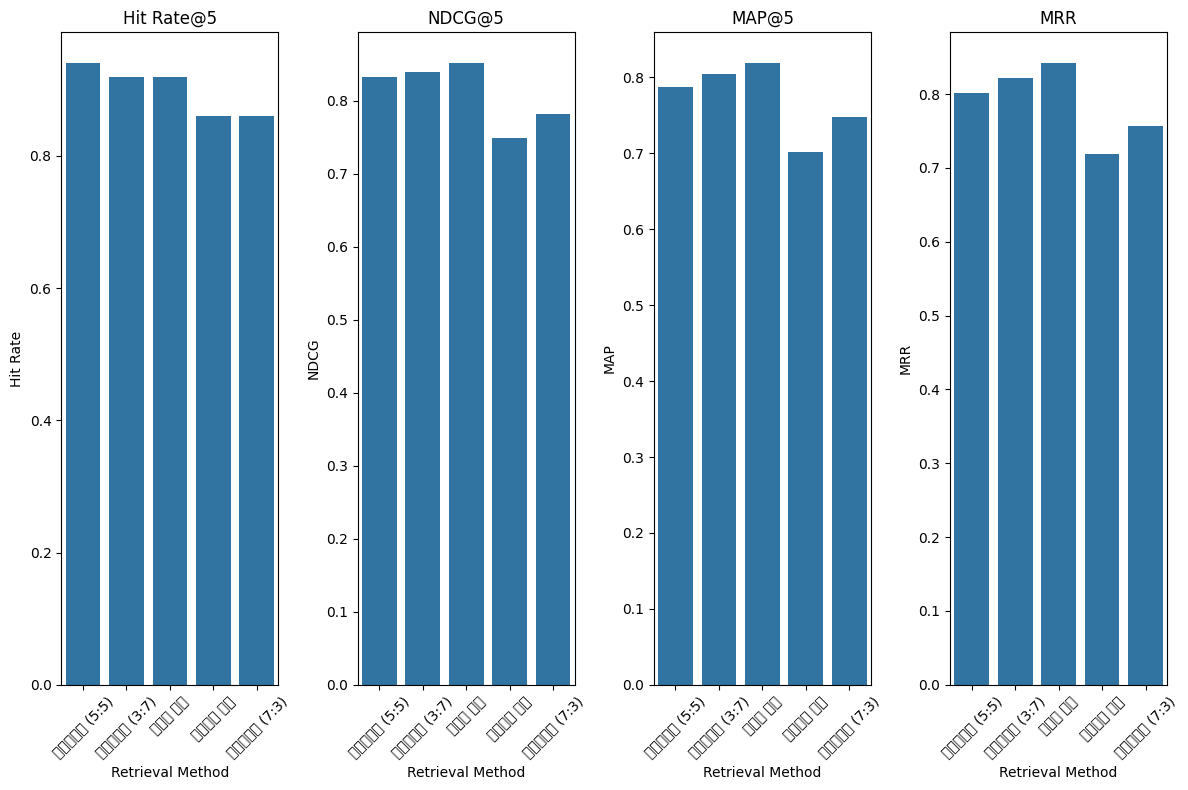

<Figure size 640x480 with 0 Axes>

In [24]:
def visualize_comparison_results(comparison_df):
    """
    검색 방법 비교 결과 시각화
    
    Args:
        comparison_df (pandas.DataFrame): 비교 결과 데이터프레임

        result = {
            "method": method_name,
            "hit_rate": ranx_k_results.get("hit_rate@5", 0),
            "ndcg": ranx_k_results.get("ndcg@5", 0),
            "map": ranx_k_results.get("map@5", 0),
            "mrr": ranx_k_results.get("mrr", 0),
        }

    """
    
    # 그래프 생성
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    sns.barplot(x=comparison_df.index, y='hit_rate', data=comparison_df, ax=ax[0])
    ax[0].set_title('Hit Rate@5')
    ax[0].set_ylabel('Hit Rate')
    ax[0].set_xlabel('Retrieval Method')        
    ax[0].tick_params(axis='x', rotation=45)

    sns.barplot(x=comparison_df.index, y='ndcg', data=comparison_df, ax=ax[1])
    ax[1].set_title('NDCG@5')
    ax[1].set_ylabel('NDCG')
    ax[1].set_xlabel('Retrieval Method')
    ax[1].tick_params(axis='x', rotation=45)                

    sns.barplot(x=comparison_df.index, y='map', data=comparison_df, ax=ax[2])
    ax[2].set_title('MAP@5')
    ax[2].set_ylabel('MAP')         
    ax[2].set_xlabel('Retrieval Method')
    ax[2].tick_params(axis='x', rotation=45)    

    sns.barplot(x=comparison_df.index, y='mrr', data=comparison_df, ax=ax[3])
    ax[3].set_title('MRR')
    ax[3].set_ylabel('MRR')
    ax[3].set_xlabel('Retrieval Method')
    ax[3].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 그래프 출력
    plt.savefig("retrieval_comparison_results.png")

# 검색 방법 비교 결과 시각화
visualize_comparison_results(comparison_results)

# 정리


##### 🔍 **의미론적 검색 (Semantic Search)**
- **정의**: 벡터 임베딩을 활용한 의미 기반 검색
- **특징**: 
  - 동의어와 문맥적 의미를 파악
  - 자연어 질의에 효과적
  - 유사도 기반 매칭
- **장점**: 의미적 연관성이 높은 문서 검색
- **단점**: 정확한 키워드 매칭 약함

##### 🔍 **키워드 검색 (Keyword Search)**
- **정의**: BM25 알고리즘 기반 키워드 매칭 검색
- **특징**:
  - 직접적인 단어/구문 매칭
  - 계산 효율성 높음
  - 전통적인 정보검색 방식
- **장점**: 정확한 키워드 매칭, 빠른 처리 속도
- **단점**: 의미적 유사성 파악 제한적

##### 🔍 **하이브리드 검색 (Hybrid Search)**
- **정의**: 키워드 검색과 의미론적 검색의 결합
- **특징**:
  - EnsembleRetriever를 통한 구현
  - 가중치 조정으로 성능 최적화
  - 두 검색 방식의 시너지 효과
- **장점**: 포괄적이고 정확한 검색 결과
- **단점**: 구현 복잡도 증가, 계산 비용 상승

In [26]:
# 데이터 준비 > 텍스트 분할기 > 문서 전처리 > 벡터 DB 생성 > *검색기* 생성 > 평가
# 하이브리드 검색기를 이용하는 경우 성능이 크게 향상이 된다. (유의미함)

# 1. 다양한 형식의 텍스트 파일 로드 함수
def load_text_files(file_patterns):
    """
    다양한 형식의 텍스트 파일을 로드
    
    Args:
        file_patterns (list): 파일 패턴 리스트
    
    Returns:
        list: Document 객체 리스트
    """
    documents = []
    
    for pattern in file_patterns:
        files = glob(pattern)
        for file_path in files:
            try:
                loader = TextLoader(file_path, encoding='utf-8')
                docs = loader.load()
                documents.extend(docs)
                print(f"✅ {file_path} 로드 완료")
            except Exception as e:
                print(f"❌ {file_path} 로드 실패: {e}")
    
    return documents

raw_documents = load_text_files(file_patterns)


# 2. 텍스트 분할기 생성 함수
def create_text_splitter():
    """
    한국어 최적화된 텍스트 분할기 생성
    """
    return RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name="cl100k_base",
        separators=['\n\n', '\n', r'(?<=[.!?])\s+'],
        chunk_size=300,
        chunk_overlap=50,
        is_separator_regex=True,
        keep_separator=True,
    )

# 문서 전처리 및 메타데이터 추가 함수
def preprocess_documents(documents, company_mapping=None):
    """
    문서 전처리 및 메타데이터 추가
    
    Args:
        documents (list): 원본 문서 리스트
        company_mapping (dict): 회사명 매핑 정보
    
    Returns:
        list: 전처리된 Document 객체 리스트
    """
    text_splitter = create_text_splitter()
    chunks = text_splitter.split_documents(documents)
    
    processed_docs = []
    for chunk in chunks:
        # 메타데이터 추가
        source_file = chunk.metadata.get('source', '')
        
        # 회사명 추출
        if company_mapping:
            company = 'unknown'
            for keyword, name in company_mapping.items():
                if keyword in source_file.lower():
                    company = name
                    break
        else:
            company = 'default'
        
        # Document 객체 생성
        doc = Document(
            # content 포맷팅에 수정을 함. >> xml 태그로 감싸고, 출처 문구 추가
            page_content=f"<Document>\n{chunk.page_content}\n</Document>\n<Source>이 문서는 '{company}'에 대한 문서입니다.</Source>",
            metadata={
                **chunk.metadata,
                'company': company,
                'language': 'ko',
                'chunk_length': len(chunk.page_content)
            }
        )
        processed_docs.append(doc)
    
    return processed_docs

# 회사명 매핑 정보
# 예시: 'tesla' -> '테슬라', 'rivian' -> '리비안'
# 실제 사용 시에는 더 많은 회사명을 추가할 수 있음
company_mapping = {
    '테슬라': '테슬라(tesla)',
    '리비안': '리비안(rivian)',
}

processed_docs = preprocess_documents(raw_documents, company_mapping)

# 3. Chroma 벡터 저장소 생성 및 로드 함수
def create_or_load_vector_store(documents, collection_name="hybrid_search_db"):
    """
    Chroma 벡터 저장소 생성 (기존 컬렉션이 있으면 로드하고, 없으면 새로 생성)
    
    Args:
        documents (list): Document 객체 리스트
        collection_name (str): 컬렉션 이름
    
    Returns:
        Chroma: 벡터 저장소 객체

    """
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    persist_directory = "./local_chroma_db"
    
    # 디렉토리와 컬렉션 파일이 존재하는지 확인
    if os.path.exists(persist_directory):
        try:
            # 기존 컬렉션 로드 시도
            vector_store = Chroma(
                collection_name=collection_name,
                embedding_function=embeddings,
                persist_directory=persist_directory
            )
            
            # 컬렉션에 문서가 있는지 확인
            if vector_store._collection.count() > 0:
                print(f"✅ 기존 벡터 저장소 로드 완료: {vector_store._collection.count()}개 문서")
                return vector_store
        except Exception as e:
            print(f"기존 컬렉션 로드 실패: {e}")
    
    # 새로운 벡터 저장소 생성
    vector_store = Chroma.from_documents(
        documents=documents,
        embedding=embeddings,
        collection_name=collection_name,
        persist_directory=persist_directory,
        collection_metadata={'hnsw:space': 'cosine'}
    )
    print(f"✅ 새 벡터 저장소 생성 완료: {vector_store._collection.count()}개 문서")
    return vector_store

# 벡터 저장소 생성
vector_store = create_or_load_vector_store(processed_docs)


################## 검색기 생성 ##################

# 의미론적 검색 함수
def semantic_search(vector_store, query, k=5):
    """
    의미론적 검색 실행
    
    Args:
        vector_store: Chroma 벡터 저장소
        query (str): 검색 쿼리
        k (int): 반환할 문서 수
    
    Returns:
        list: 검색된 Document 객체 리스트
    """
    # 검색기 생성
    retriever = vector_store.as_retriever(search_kwargs={"k": k})
    
    # 검색 실행
    results = retriever.invoke(query)
        
    return results

# 검색 테스트
query = "리비안은 언제 설립되었나요?"
semantic_results = semantic_search(vector_store, query, k=3)

print(f"Query: {query}")
print(f"🔍 의미론적 검색 결과 ({len(semantic_results)}개)")
for i, doc in enumerate(semantic_results, 1):
    print(f"\n[{i}] 회사: {doc.metadata.get('company', 'N/A')}")
    print(f"내용: {doc.page_content[:150]}...")
    print("-" * 50)


# 키워드 검색기 생성 함수
def setup_korean_tokenizer():
    """
    한국어 토크나이저 설정
    
    Returns:
        Kiwi: 한국어 토크나이저 객체
    """
    kiwi = Kiwi()
    
    # 사용자 정의 단어 추가 > 별도의 명사로 인지 할 수 있게 됨.
    custom_words = [
        ('리비안', 'NNP'),  # 고유명사
        ('테슬라', 'NNP'),  # 고유명사
        ('전기차', 'NNG'),  # 일반명사
    ]
    
    for word, pos in custom_words:
        kiwi.add_user_word(word, pos)
        print(f"✅ 단어 추가: {word} ({pos})")
    
    return kiwi

def korean_tokenizer(text, kiwi_model):
    """
    한국어 토크나이저 함수
    
    Args:
        text (str): 토큰화할 텍스트
        kiwi_model: Kiwi 모델 객체
    
    Returns:
        list: 토큰 리스트
    """
    return [token.form for token in kiwi_model.tokenize(text)]

# 토크나이저 설정
kiwi_model = setup_korean_tokenizer()

# 토큰화 테스트
test_text = "리비안은 언제 설립되었나요?"
tokens = korean_tokenizer(test_text, kiwi_model)
print(f"원문: {test_text}")
print(f"토큰: {tokens}")



# BM25 검색기 생성 함수
def create_bm25_retriever(documents, kiwi_model, k=5):
    """
    BM25 검색기 생성
    
    Args:
        documents (list): Document 객체 리스트
        kiwi_model: Kiwi 토크나이저
        k (int): 반환할 문서 수
    
    Returns:
        BM25Retriever: BM25 검색기 객체
    """
    def preprocess_func(text):
        return korean_tokenizer(text, kiwi_model)
    
    # BM25 검색기 생성 >> 구문 일치 
    bm25_retriever = BM25Retriever.from_documents(
        documents=documents,
        preprocess_func=preprocess_func,
        k=k
    )
    
    print(f"✅ BM25 검색기 생성 완료: {len(documents)}개 문서 인덱싱")
    return bm25_retriever

# BM25 검색기 생성
bm25_retriever = create_bm25_retriever(processed_docs, kiwi_model, k=3)
keyword_results = bm25_retriever.invoke(query)

print(f"Query: {query}")
print(f"🔍 키워드 검색 결과 ({len(keyword_results)}개)")
for i, doc in enumerate(keyword_results, 1):
    print(f"\n[{i}] 회사: {doc.metadata.get('company', 'N/A')}")
    print(f"내용: {doc.page_content[:150]}...")
    print("-" * 50)
def analyze_bm25_scores(bm25_retriever, query, kiwi_model, top_k=5):
    """
    BM25 점수 분석
    
    Args:
        bm25_retriever: BM25 검색기
        query (str): 검색 쿼리
        kiwi_model: Kiwi 토크나이저
        top_k (int): 상위 k개 결과
    """
    # 쿼리 토큰화
    tokenized_query = korean_tokenizer(query, kiwi_model)
    print(f"쿼리 토큰: {tokenized_query}")
    
    # BM25 점수 계산
    doc_scores = bm25_retriever.vectorizer.get_scores(tokenized_query)
    
    # 점수 정렬
    doc_scores_sorted = sorted(
        enumerate(doc_scores), 
        key=lambda x: x[1], 
        reverse=True
    )
    
    print(f"\n📊 상위 {top_k}개 문서의 BM25 점수:")
    print("-" * 80)
    
    for rank, (idx, score) in enumerate(doc_scores_sorted[:top_k], 1):
        doc = bm25_retriever.docs[idx]
        print(f"[{rank}] 점수: {score:.4f}")
        print(f"    회사: {doc.metadata.get('company', 'N/A')}")
        print(f"    내용: {doc.page_content[:100]}...")
        print("-" * 80)

# BM25 점수 분석
analyze_bm25_scores(bm25_retriever, query, kiwi_model)



############################################

# 하이브리드 검색기 생성 함수
def create_hybrid_retriever(vector_store, bm25_retriever, weights=None):
    """
    하이브리드 검색기 생성
    
    Args:
        vector_store: 벡터 저장소
        bm25_retriever: BM25 검색기
        weights (list): 가중치 [의미론적, 키워드]
    
    Returns:
        EnsembleRetriever: 하이브리드 검색기
    """
    if weights is None:
        weights = [0.5, 0.5]  # 기본값: 동일한 가중치
    
    # 의미론적 검색기 생성
    semantic_retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    
    # 앙상블 검색기 생성
    ensemble_retriever = EnsembleRetriever(
        retrievers=[semantic_retriever, bm25_retriever],
        weights=weights
    )
    
    print(f"✅ 하이브리드 검색기 생성 완료")
    print(f"   가중치: 의미론적 {weights[0]}, 키워드 {weights[1]}")
    
    return ensemble_retriever

# 하이브리드 검색기 생성
hybrid_retriever = create_hybrid_retriever(vector_store, bm25_retriever)
# 검색 테스트
hybrid_results = hybrid_retriever.invoke(query)

print(f"Query: {query}")
print(f"🔍 하이브리드 검색 결과 ({len(hybrid_results)}개)")
for i, doc in enumerate(hybrid_results, 1):
    print(f"\n[{i}] 회사: {doc.metadata.get('company', 'N/A')}")
    print(f"내용: {doc.page_content[:150]}...")
    print("-" * 50)




############################################
# 평가

# 평가 데이터셋 로드 함수
def load_evaluation_dataset(file_path):
    """
    평가 데이터셋 로드
    
    Args:
        file_path (str): 평가 데이터 파일 경로
    
    Returns:
        pandas.DataFrame: 평가 데이터셋
    """
    try:
        if file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        elif file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("지원하지 않는 파일 형식")
        
        print(f"✅ 평가 데이터셋 로드: {len(df)}개 질문")
        return df
    except Exception as e:
        print(f"❌ 데이터셋 로드 실패: {e}")
        return None

# 평가 데이터셋 로드
eval_df = load_evaluation_dataset("./data/synthetic_testset.csv")

def prepare_evaluation_data(df):
    """
    평가 데이터 전처리
    
    Args:
        df (pandas.DataFrame): 원본 데이터프레임
    
    Returns:
        tuple: (질문 리스트, 정답 문서 리스트)
    """
    questions = df['user_input'].tolist()
    
    # 정답 문서 파싱
    reference_contexts = []
    for contexts in df['reference_contexts']:
        if isinstance(contexts, str):
            # 문자열을 리스트로 변환
            context_list = eval(contexts)
        else:
            context_list = contexts
        
        # Document 객체로 변환
        docs = [Document(page_content=ctx) for ctx in context_list]
        reference_contexts.append(docs)
    
    return questions, reference_contexts

# 평가 데이터 전처리
questions, reference_contexts = prepare_evaluation_data(eval_df)

def clean_document_content(doc_content):
    """
    문서 내용을 정규화하여 매칭 가능하도록 처리
    """
    if not doc_content:
        return ""
    
    # 문자열로 변환
    content = str(doc_content)
    
    # <Document> 태그 제거
    content = content.replace('<Document>', '').replace('</Document>', '')
    
    # 시작과 끝의 공백/개행 제거
    content = content.strip()
    
    # 연속된 공백을 단일 공백으로 변경
    import re
    content = re.sub(r'\s+', ' ', content)
    
    # 처음 100자만 사용 (고유 식별을 위해)
    return content[:100]

def evaluate_with_ranx(retriever, questions, reference_contexts, k=5):
    """
    ranx 라이브러리를 사용한 검색 성능 평가
    """
    # ranx 설치 확인
    try:
        from ranx import Qrels, Run, evaluate
    except ImportError:
        print("❌ ranx 라이브러리를 설치해주세요: pip install ranx")
        return None
    
    def extract_clean_content(doc):
        """문서에서 깔끔한 내용을 추출"""
        if doc is None:
            return None
            
        # 문자열인 경우
        if isinstance(doc, str):
            return clean_document_content(doc)
        
        # 딕셔너리인 경우
        if isinstance(doc, dict):
            # 여러 필드 시도
            for field in ['page_content', 'content', 'text', 'body']:
                if field in doc:
                    return clean_document_content(doc[field])
        
        # 문서 객체인 경우 (예: Langchain Document)
        if hasattr(doc, 'page_content'):
            return clean_document_content(doc.page_content)
        elif hasattr(doc, 'content'):
            return clean_document_content(doc.content)
        
        # 마지막 수단: 객체를 문자열로 변환
        return clean_document_content(str(doc))
    
    # 데이터 형식 변환
    qrels_dict = {}
    run_dict = {}
    
    print("🔄 검색 및 평가 데이터 준비 중...")
    
    total_matches = 0
    total_queries = len(questions)
    
    for i, (question, ref_docs) in enumerate(zip(questions, reference_contexts)):
        query_id = f"q_{i+1}"
        
        try:
            # 검색 실행
            retrieved_docs = retriever.invoke(question)
            
            # 정답 문서 내용 정규화
            ref_doc_contents = set()
            for ref_doc in ref_docs:
                clean_content = extract_clean_content(ref_doc)
                if clean_content:
                    ref_doc_contents.add(clean_content)
            
            # 검색된 문서 내용 정규화 및 점수 부여
            retrieved_doc_scores = {}
            found_relevant = 0
            
            for j, ret_doc in enumerate(retrieved_docs[:k]):
                clean_content = extract_clean_content(ret_doc)
                if clean_content:
                    # 점수는 순위 기반 (1위가 가장 높은 점수)
                    score = k - j
                    retrieved_doc_scores[clean_content] = score
                    
                    # 정답 문서에 포함되어 있는지 확인
                    if clean_content in ref_doc_contents:
                        found_relevant += 1
            
            # Qrels 형식: 정답 문서들에 대해 관련성 점수 1 부여
            qrels_dict[query_id] = {content: 1 for content in ref_doc_contents}
            
            # Run 형식: 검색 결과의 점수
            run_dict[query_id] = retrieved_doc_scores
            
            total_matches += found_relevant
            
            print(f"✅ 질문 {i+1} 처리 완료")
            print(f"  질문: {question[:50]}...")
            print(f"  검색된 문서 수: {len(retrieved_docs[:k])}")
            print(f"  정답 문서 수: {len(ref_doc_contents)}")
            print(f"  발견된 관련 문서 수: {found_relevant}")
            
            # 디버깅 정보 (매칭 확인용)
            if found_relevant > 0:
                print(f"  ✅ 매칭 성공!")
            else:
                print(f"  ❌ 매칭 실패")
                # 첫 번째 정답과 검색 결과 비교
                if ref_doc_contents and retrieved_doc_scores:
                    first_ref = list(ref_doc_contents)[0]
                    first_ret = list(retrieved_doc_scores.keys())[0]
                    print(f"    정답[0]: '{first_ref[:50]}...'")
                    print(f"    검색[0]: '{first_ret[:50]}...'")
            
            print("-" * 60)
            
        except Exception as e:
            print(f"❌ 질문 {i+1} 처리 중 오류: {e}")
            # 빈 결과로 설정
            qrels_dict[query_id] = {}
            run_dict[query_id] = {}
            continue
    
    print(f"📊 전체 매칭 통계: {total_matches}개 문서가 {total_queries}개 질문에서 매칭됨")
    
    # 빈 결과 확인
    empty_qrels = [q for q, docs in qrels_dict.items() if not docs]
    empty_runs = [q for q, docs in run_dict.items() if not docs]
    
    if empty_qrels:
        print(f"⚠️  정답이 없는 쿼리: {empty_qrels}")
    if empty_runs:
        print(f"⚠️  검색 결과가 없는 쿼리: {empty_runs}")
    
    # ranx 객체 생성
    try:
        qrels = Qrels(qrels_dict, name="Retrieval_Evaluation")
        run = Run(run_dict, name="Retriever_Results")
    except Exception as e:
        print(f"❌ ranx 객체 생성 오류: {e}")
        return None
    
    # 평가 메트릭 계산
    metrics = [f"hit_rate@{k}", f"ndcg@{k}", f"map@{k}", "mrr"]
    
    try:
        results = evaluate(qrels, run, metrics)
        
        print("\n📊 ranx 평가 결과:")
        print("=" * 40)
        for metric, score in results.items():
            print(f"  {metric:<15}: {score:.4f}")
        
        # 추가 통계
        print(f"\n📈 매칭 통계:")
        print(f"  전체 매칭 문서 수: {total_matches}")
        print(f"  평균 매칭률: {total_matches / (total_queries * k):.2%}")
        
        return results
        
    except Exception as e:
        print(f"❌ 평가 계산 오류: {e}")
        
        # 개별 메트릭으로 재시도
        results = {}
        for metric in metrics:
            try:
                score = evaluate(qrels, run, metric)
                results[metric] = score
                print(f"  {metric:<15}: {score:.4f}")
            except Exception as metric_error:
                print(f"  {metric:<15}: ERROR - {metric_error}")
        
        return results
        

# 평가 실행
ranx_results = evaluate_with_ranx(
    hybrid_retriever, 
    questions, 
    reference_contexts,
    k=5
)


# ranx-k 평가 실행 (rouge 점수가 높은 경우) -> 문자열 유사도 기반 평가
ranx_k_results = evaluate_with_ranx_similarity(
    retriever=hybrid_retriever,
    questions=questions,
    reference_contexts=reference_contexts,
    k=5,
    method='kiwi_rouge',  
    similarity_threshold=0.8,
)

# ranx-k 평가 실행 (embedding 점수가 높은 경우) -> 의미적 유사도 기반 평가
ranx_k_results = evaluate_with_ranx_similarity(
    retriever=hybrid_retriever,
    questions=questions,
    reference_contexts=reference_contexts,
    k=5,
    method='embedding',  
    embedding_model="BAAI/bge-m3",
    similarity_threshold=0.9
)



#########################
## 다양한 검색 방법 성능 비교
def compare_retrieval_methods(vector_store, bm25_retriever, questions, reference_contexts, k=5):
    """
    다양한 검색 방법 성능 비교
    
    Args:
        vector_store: 벡터 저장소
        bm25_retriever: BM25 검색기
        questions (list): 질문 리스트
        reference_contexts (list): 정답 문서 리스트
        k (int): 평가할 상위 k개 결과
    
    Returns:
        pandas.DataFrame: 비교 결과
    """
    results = []
    
    # 검색 방법들 정의
    bm25_retriever.k = k
    retrievers = {
        "의미론적 검색": vector_store.as_retriever(search_kwargs={"k": k}),
        "키워드 검색": bm25_retriever,
        "하이브리드 (5:5)": create_hybrid_retriever(vector_store, bm25_retriever, [0.5, 0.5]),
        "하이브리드 (7:3)": create_hybrid_retriever(vector_store, bm25_retriever, [0.7, 0.3]),
        "하이브리드 (3:7)": create_hybrid_retriever(vector_store, bm25_retriever, [0.3, 0.7]),
    }
    
    for method_name, retriever in retrievers.items():
        print(f"🔄 {method_name} 평가 중...")
        
        # ranx-k 평가 실행 (rouge 점수가 높은 경우) -> 문자열 유사도 기반 평가
        ranx_k_results = evaluate_with_ranx_similarity(
            retriever=retriever,
            questions=questions,
            reference_contexts=reference_contexts,
            k=k,
            method='kiwi_rouge',  
            similarity_threshold=0.8,
        )
        
        # 평가 결과 정리 
        result = {
            "method": method_name,
            "hit_rate": ranx_k_results.get("hit_rate@5", 0),
            "ndcg": ranx_k_results.get("ndcg@5", 0),
            "map": ranx_k_results.get("map@5", 0),
            "mrr": ranx_k_results.get("mrr", 0),
        }

        results.append(result)

    # 결과 DataFrame 생성
    results_df = pd.DataFrame(results)
    results_df.set_index("method", inplace=True)
    results_df.sort_values(by="hit_rate", ascending=False, inplace=True)

    return results_df


# 검색 방법 성능 비교
comparison_results = compare_retrieval_methods(vector_store, bm25_retriever, questions, reference_contexts, k=5)


def visualize_comparison_results(comparison_df):
    """
    검색 방법 비교 결과 시각화
    
    Args:
        comparison_df (pandas.DataFrame): 비교 결과 데이터프레임

        result = {
            "method": method_name,
            "hit_rate": ranx_k_results.get("hit_rate@5", 0),
            "ndcg": ranx_k_results.get("ndcg@5", 0),
            "map": ranx_k_results.get("map@5", 0),
            "mrr": ranx_k_results.get("mrr", 0),
        }

    """
    
    # 그래프 생성
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    sns.barplot(x=comparison_df.index, y='hit_rate', data=comparison_df, ax=ax[0])
    ax[0].set_title('Hit Rate@5')
    ax[0].set_ylabel('Hit Rate')
    ax[0].set_xlabel('Retrieval Method')        
    ax[0].tick_params(axis='x', rotation=45)

    sns.barplot(x=comparison_df.index, y='ndcg', data=comparison_df, ax=ax[1])
    ax[1].set_title('NDCG@5')
    ax[1].set_ylabel('NDCG')
    ax[1].set_xlabel('Retrieval Method')
    ax[1].tick_params(axis='x', rotation=45)                

    sns.barplot(x=comparison_df.index, y='map', data=comparison_df, ax=ax[2])
    ax[2].set_title('MAP@5')
    ax[2].set_ylabel('MAP')         
    ax[2].set_xlabel('Retrieval Method')
    ax[2].tick_params(axis='x', rotation=45)    

    sns.barplot(x=comparison_df.index, y='mrr', data=comparison_df, ax=ax[3])
    ax[3].set_title('MRR')
    ax[3].set_ylabel('MRR')
    ax[3].set_xlabel('Retrieval Method')
    ax[3].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 그래프 출력
    plt.savefig("retrieval_comparison_results.png")

# 검색 방법 비교 결과 시각화
visualize_comparison_results(comparison_results)

✅ data\리비안_KR.md 로드 완료
✅ data\테슬라_KR.md 로드 완료
✅ 기존 벡터 저장소 로드 완료: 39개 문서
Query: 리비안은 언제 설립되었나요?
🔍 의미론적 검색 결과 (3개)

[1] 회사: unknown
내용: <Document>
- **회사 유형:** 상장
- **거래소:** NASDAQ: RIVN
- **설립:** 2009년 6월, 플로리다 주 록ledge
- **설립자:** R. J. 스캐린지
- **본사:** 미국 캘리포니아 주 어바인
- **서비스 지역:** 북미
-...
--------------------------------------------------

[2] 회사: unknown
내용: <Document>
Rivian Automotive, Inc.는 2009년에 설립된 미국의 전기 자동차 제조업체, 자동차 기술 및 야외 레크리에이션 회사입니다.

**주요 정보:**
</Document>
<Source>이 문서는 'unknown'에 대한 문서입니다.</...
--------------------------------------------------

[3] 회사: unknown
내용: <Document>
Tesla는 내부 고발자 보복, 근로자 권리 침해, 안전 결함, 홍보 부족, Musk의 논란의 여지가 있는 발언과 관련된 소송, 정부 조사 및 비판에 직면했습니다.

## 역사

### 창립 (2003–2004)

Tesla Motors, Inc.는...
--------------------------------------------------
✅ 단어 추가: 리비안 (NNP)
✅ 단어 추가: 테슬라 (NNP)
✅ 단어 추가: 전기차 (NNG)
원문: 리비안은 언제 설립되었나요?
토큰: ['리비안', '은', '언제', '설립', '되', '었', '나요', '?']
✅ BM25 검색기 생성 완료: 39개 문서 인덱싱
Query: 리비안은 언제 설립되었나요?
🔍 키워드 검색 결과 (3개)

[1] 회사: unkn

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:20<00:00,  2.26it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.940
  ndcg@5: 0.835
  map@5: 0.789
  mrr: 0.813

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.842 (64/76)
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: embedding, Threshold | 임계값: 0.9, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.970
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False positives | 거짓 긍정

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [01:52<00:00,  2.39s/it]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (embedding):
  hit_rate@5: 0.940
  ndcg@5: 0.835
  map@5: 0.789
  mrr: 0.813

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.9
  Overall recall | 전체 재현율: 0.842 (64/76)
✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.5, 키워드 0.5
✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.7, 키워드 0.3
✅ 하이브리드 검색기 생성 완료
   가중치: 의미론적 0.3, 키워드 0.7
🔄 의미론적 검색 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 M

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:23<00:00,  2.01it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.860
  ndcg@5: 0.749
  map@5: 0.702
  mrr: 0.718

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.789 (60/76)
🔄 키워드 검색 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 False

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:01<00:00, 24.79it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.920
  ndcg@5: 0.851
  map@5: 0.818
  mrr: 0.842

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.816 (62/76)
🔄 하이브리드 (5:5) 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:18<00:00,  2.60it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.940
  ndcg@5: 0.832
  map@5: 0.787
  mrr: 0.802

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.855 (65/76)
🔄 하이브리드 (7:3) 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:23<00:00,  2.02it/s]



📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.860
  ndcg@5: 0.782
  map@5: 0.747
  mrr: 0.757

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.789 (60/76)
🔄 하이브리드 (3:7) 평가 중...
🔍 Starting similarity-based ranx evaluation | 유사도 기반 ranx 평가 시작
   Method | 방법: kiwi_rouge, Threshold | 임계값: 0.8, Mode | 모드: reference_based
   📊 Reference-based mode: Will calculate proper recall metrics | 참조 기반 모드: 정확한 재현율 계산

🔍 Question | 질문 1: Rivian Automotive, Inc.의 설립 연도와 주요 사업 분야는 무엇입니까?...
📊 Reference docs | 참조 문서: 1, Retrieved docs | 검색 문서: 5
📊 Similarity matrix shape | 유사도 매트릭스 shape: (1, 5)
📈 Max similarity | 최대 유사도: 0.800
📋 Qrels items | qrels 항목 수: 1
📋 Run items | run 항목 수: 5
📋 Reference docs found | 참조 문서 발견: 1/1
📋 

ranx similarity evaluation | ranx 유사도 평가: 100%|██████████| 50/50 [00:18<00:00,  2.50it/s]


📊 Similarity-based ranx evaluation results | 유사도 기반 ranx 평가 결과 (kiwi_rouge):
  hit_rate@5: 0.920
  ndcg@5: 0.839
  map@5: 0.804
  mrr: 0.822

📈 Analysis information | 분석 정보:
  Total queries | 총 질문 수: 50
  Total retrieved docs | 총 검색 문서 수: 250
  Avg docs per query | 질문당 평균 검색 문서: 5.0
  Total relevant docs | 관련 문서 총 개수: 76
  Avg relevant per query | 질문당 평균 관련 문서: 1.5
  Threshold used | 사용된 임계값: 0.8
  Overall recall | 전체 재현율: 0.816 (62/76)
